In [25]:
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
from matplotlib import pyplot as plt
import libfmp.b

In [2]:
csv_test = pd.read_csv('../corpus/chords_sequences/Soulville.csv')
# csv_test

In [3]:
y_test, sr_test = librosa.load('../../big_corpus/wav_music21/Soulville.wav')

In [5]:
csv_test

,Measure,Soulville,chord_note,Time
0,1,Bb,Bb,0.0
1,34,Bbmin7,Bb,66.0
2,35,Ebmin7,Eb,68.0
3,36,Bbmin7,Bb,70.0
4,37,Bb7,Bb,72.0
5,38,Ebmin7,Eb,74.0
6,39,Ebmin7,Eb,76.0
7,40,Bbmin7,Bb,78.0
8,41,Bbmin9,Bb,80.0
9,42,Cmin7,C,82.0


Convertendo para segundos:

In [12]:
segs = np.linspace(0,
                   len(y_test)/sr_test, 
                   num=len(y_test))

Text(0.5, 0, 'time (s)')

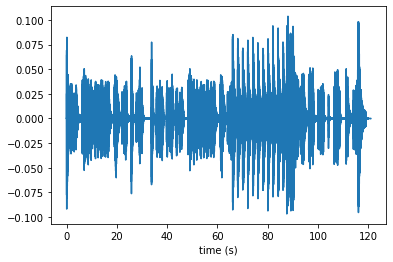

In [13]:
plt.plot(segs, y_test)
plt.xlabel('time (s)')

In [14]:
df_test = pd.DataFrame({'seconds':segs, 'signal': y_test})

In [15]:
df_test

,seconds,signal
0,0.000000,0.000035
1,0.000045,0.000029
2,0.000091,-0.000029
3,0.000136,-0.000117
4,0.000181,-0.000222
...,...,...
2668055,121.000272,-0.000002
2668056,121.000317,-0.000005
2668057,121.000363,-0.000003
2668058,121.000408,-0.000004


In [16]:
csv_test

,Measure,Soulville,chord_note,Time
0,1,Bb,Bb,0.0
1,34,Bbmin7,Bb,66.0
2,35,Ebmin7,Eb,68.0
3,36,Bbmin7,Bb,70.0
4,37,Bb7,Bb,72.0
5,38,Ebmin7,Eb,74.0
6,39,Ebmin7,Eb,76.0
7,40,Bbmin7,Bb,78.0
8,41,Bbmin9,Bb,80.0
9,42,Cmin7,C,82.0


In [10]:
# cut = 1.5
# df_cut = df_test[df_test.seconds < cut]
# # df_chroma = 
# chroma_test = librosa.feature.chroma_stft(y=df_cut['signal'].values, 
#                                         sr=sr_test, 
#                                         tuning=0, 
#                                         norm=None, 
#                                         hop_length=len(df_cut), 
#                                         n_fft=len(df_cut))


# plt.plot(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'],
#           chroma_test);

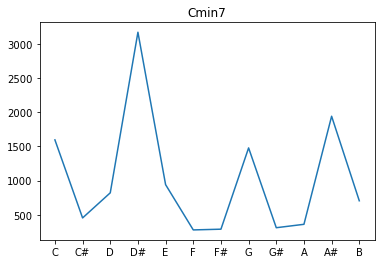

<Figure size 432x288 with 0 Axes>

In [41]:
# for i in csv_test.index:

chord = csv_test.iloc[9]['Soulville']

if 9 != len(csv_test) - 1:
    cut = csv_test.iloc[9]['Time']
    cut_forw = csv_test.iloc[9+1]['Time'] # o acorde dura até o instante em que entra o acorde seguinte
    df_cut = df_test[(df_test.seconds > cut) & (df_test.seconds < cut_forw)]            

else:
    cut = csv_test.iloc[9]['Time']
    df_cut = df_test[df_test.seconds > cut]


N = len(df_cut['signal'].values)
chroma = librosa.feature.chroma_stft(y=df_cut['signal'].values, 
                                        sr=sr_test, 
                                        tuning=0.0, 
                                        norm=0, 
                                        hop_length=N+1, 
                                        n_fft=N
                                    )


plt.plot(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'],
          chroma);

plt.title(chord);
plt.show()
plt.clf()

# plt.plot(chroma)

O vetor acima (com 12 componentes) é um exemplo do que será o input do nosso modelo. Vemos que realmente faz sentido, visto que no trecho escolhido a harmonia ali presente é Cmin7 e, de fato, as principais frequências que encontramos foram C, Eb (que é o mesmo que D# acusticamente), G e Bb (que é o mesmo que A# acusticamente), notas que compõem este acorde.

Ideia: trocar tudo de bemol pra sustenido ou o contrário. Porque se não, teremos chromas com mesmas frequências e nomes diferentes.

### Generalizando:

In [96]:
chords_folder = '../corpus/chords_sequences/'
audios_folder = '../../big_corpus/wav_music21/'
notes = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

songs_with_errors = []

# counter = 0
for file in os.listdir(chords_folder):
    
    chords = pd.read_csv(chords_folder + file)
    name = file.split('.csv')[0]
    
    try:
        print(name)
        y, sr = librosa.load(audios_folder + name + '.wav')

        segs = np.linspace(0, len(y)/sr, num=len(y))

        # criando um df com o sinal sincronizado com o tempo em segundos
        df = pd.DataFrame({'seconds':segs, 
                           'signal': y})

        # adicionando uma coluna para cada componente do chroma
        chords_concat = pd.DataFrame(columns = notes, 
                                     index = chords.index)

        chords = pd.concat([chords, chords_concat], axis=1)


        for i in chords.index:

            chord = chords.iloc[i][name]

            if i != len(chords) - 1:
                cut = chords.iloc[i]['Time']
                cut_forw = chords.iloc[i+1]['Time'] # o acorde dura até o instante em que entra o acorde seguinte
                df_cut = df[(df.seconds > cut) & (df.seconds < cut_forw)]            

            else: # se for o último acorde, não precisamos parar antes do acorde seguinte (pois não existe)
                cut = chords.iloc[i]['Time']
                df_cut = df[df.seconds > cut]

#             print(name)

            chroma = librosa.feature.chroma_stft(y=df_cut['signal'].values, 
                                                    sr=sr, 
                                                    tuning=0.0, 
                                                    norm=0, 
                                                    hop_length=len(df_cut)+1, 
                                                    n_fft=len(df_cut)
                                                )

            for n, note in enumerate(notes):

                chords.at[i, note] = chroma[n].item()


        chords.to_csv('../corpus/chords_and_chromas/{}.csv'.format(name))
        print(name)
        
    except ValueError:
        songs_with_errors.append(name)
            
#         chords.at[i, notes] = chroma

#         plt.plot(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'],
#                   chroma);
#         plt.title(chord);
#         plt.savefig('test_figures/{}_{}_chroma_example_{}.png'.format(name, chord, counter))
#         plt.clf()
        
#         counter += 1

BlueBossa
BlueBossa
PutItInYourPocket
PutItInYourPocket
For Mods Only
For Mods Only
Soulville
Soulville
MamboInn
MamboInn
Whilemyladysleeps
Whilemyladysleeps
Theme
Theme
SoulStation
SoulStation
SomethingElse
SomethingElse
MoldPopJazz
MoldPopJazz
lhcd
lhcd
MelodyForC
MelodyForC
IsYouIsOrIsYouAintMyBaby
IsYouIsOrIsYouAintMyBaby
BeautifulLove
BeautifulLove
BrotherHubbard
BrotherHubbard
Root Down
Root Down
MysticBrew
MysticBrew
Cold duck Lead
Cold duck Lead
FunkInDeepFreeze
FunkInDeepFreeze
HiHeelSneakers_BlueJuice
HiHeelSneakers_BlueJuice
Clouds
Clouds
Midnight Blue
Midnight Blue
FWS
FWS
LullabyOfTheLeaves
LullabyOfTheLeaves
Jazz Crimes
Jazz Crimes
AllOfMe_SaxTranscription_F
AllOfMe_SaxTranscription_F
Dumaine St
Dumaine St
gonehomeC#
gonehomeC#
728
728
HeadinHome
HeadinHome
Lotus Blossom
Lotus Blossom
Groovin'
Groovin'
dat dere
dat dere
Cat, TheEb
Cat, TheEb
AppointmentInGhana
AppointmentInGhana
Cinnamon and Clove
Cinnamon and Clove
psychedelic sally C
psychedelic sally C
Tune 88
Tune 88


ColdDuckTimeII
Blues For Junior
Blues For Junior
PastorT
Why!
Why!
WaterSign
WaterSign
Ravayah
Ravayah
Back at the Chicken Shack
Back at the Chicken Shack
ThereWillNeverBeAnotherYou
ThereWillNeverBeAnotherYou
sambop
sambop
HomeFires
HomeFires
MrMagicII
MrMagicII
gonehome
gonehome
Arriving Soon
Arriving Soon
JustFriends
JustFriends
ItCouldHappenToYou
ItCouldHappenToYou
Night And DAy
Night And DAy
Black Ice
Black Ice
Hattie Wall - 004 Mallets
Hattie Wall - 004 Mallets
630blues
630blues
Spain
Spain
Cryin Blues
Cryin Blues
MudSauce
WhenTheSunComesDown
WhenTheSunComesDown
JumpinWithSymphonySid
JumpinWithSymphonySid
Blues on Sunday
Blues on Sunday
1974 Blues
1974 Blues
TheInCrowd
TheInCrowd
Solid
Solid
Sonny's Crib
Sonny's Crib
WayBackHome
WayBackHome
Rain Dance
Rain Dance
Cold Duck B with bass
Cold Duck B with bass
Remember
Remember
Summertime
Summertime
1612
1612
Yeah You Right
Yeah You Right
8CountsForRita
8CountsForRita
Grand Strut
Grand Strut
StickyJuly
StickyJuly
Love For Sale
Love For

In [99]:
songs_with_errors

['the worm',
 'DukesTheme',
 'ImNotSoSureI',
 'RioFunk',
 'TheZone',
 'CrisisC#',
 'GirlOfMyDreams',
 'Just the Two of Us',
 'Set Us Free',
 'YoungRabbitsThe',
 'dorado 3',
 'SuperstitionII',
 'CowFunque',
 'Crisis',
 'Superstition',
 'Too Many Rivers To Cross',
 'ItAintNec(Sting)',
 'Humanism',
 'PastorT',
 'MudSauce',
 'Soul Power74',
 'herzog',
 'Blue Juice']

Salvando músicas com problemas em um arquivo txt:

In [102]:
with open('songs_with_errors.txt', 'w') as f:
    for line in songs_with_errors:
        f.write(f"{line}\n")